# Partisan Hashtags

Almost everyone in Congress has a Twitter account.
Twitter even [released a guide](http://www.npr.org/sections/itsallpolitics/2015/09/30/443128829/twitter-has-a-136-page-handbook-for-politicians-140-character-tweets) for politicians to effectively use the platform.
For one thing, it's another social channel to communicate with constituents (looking at you, [@CoryBooker](https://twitter.com/CoryBooker)).
More interestingly it's also used to promote awareness of certain political issues and push agendas.
Most people use hashtags for pointless stuff or shamelessly self promote:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Head Over To <a href="https://twitter.com/poolafterdark">@poolafterdark</a> Right Now !!! Let&#39;s GoO !!! <a href="https://twitter.com/hashtag/DJPaulyD?src=hash">#DJPaulyD</a> <a href="https://twitter.com/hashtag/paulyd?src=hash">#paulyd</a> <a href="https://twitter.com/hashtag/50Cent?src=hash">#50Cent</a></p>&mdash; DJ Pauly D (@DJPaulyD) <a href="https://twitter.com/DJPaulyD/status/731681221663698945">May 15, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Politicians, on the other hand, will use it for stuff like this:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">House takes step to responsibly address <a href="https://twitter.com/hashtag/PuertoRico?src=hash">#PuertoRico</a> crisis, avoid taxpayer bailout. <a href="https://t.co/sUNKIxUkdC">https://t.co/sUNKIxUkdC</a></p>&mdash; Paul Ryan (@SpeakerRyan) <a href="https://twitter.com/SpeakerRyan/status/736003731104366592">May 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

When a politican hashtags (yeah it's a verb too) something it's usually part of a political discussion.
If we took all of the tweets made by members of Congress, what would the hashtags tell us about the goings-on in DC?
Which topics are most pressing right now? Who's influencing the discussion?

These are exactly the types of questions we can answer with [graph theory](https://en.wikipedia.org/wiki/Graph_theory), which represents objects as _nodes_ and connections between them as _edges_.
It's often used to model things like the electrical grid (power stations are nodes and power lines as edges) or Facebook's social network (people are nodes and friendships are edges).
We can use the hashtags and the people who tweeted them to construct a mathematical model that will allow us to statistically check out what's going on.

I've collected a full week's worth of hashtags used by every member of Congress using the [Sunlight Foundation's Congress API](https://sunlightlabs.github.io/congress/) and [tweetshovel](https://github.com/timothyrenner/tweetshovel), a command line tool I wrote to scrape large numbers of tweets.
Because Twitter has rate limits for pulling tweets and some slowness in tweetshovel it took a very long time to collect the data.
The repository has details on how to run it yourself if you want to pull new data.

In [24]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_context("notebook", font_scale=1.75)

%matplotlib inline

In [25]:
# Read the Congress and hashtag data.
congress = pd.read_csv('data/congress.csv', index_col = 'twitter')
hashtags = pd.read_csv('data/congress_last_week_tags.csv', index_col='name')

## Hashtag to Hashtag

One way to construct the model is to treat each hashtag as a node in the graph, connecting them when the same legislator uses them.
So two hashtag nodes **#puertorico** and **#zika** would be connected when Paul Ryan tweets about both subjects.
I'll also add a *weight* to edges that appear multiple times (for example, if Mitch McConnell also tweeted the same hashtags ... as if) so connections that appear multiple times are stronger.
If we apply that logic to every hashtag used by every member of Congress we'd have a model of the topics discussed in Congress and how they're related.

In [26]:
# Build the nodes. We can represent the nodes as a pandas data frame.
tags_with_party = hashtags.join(congress, how='inner').drop(['time','name'], 1)

# We'll want to track how many times members of each party use the hashtags.
# We do this with two separate group-by operations ...
republican_tags = tags_with_party[tags_with_party.party == 'R'].groupby(['tag']).count()
democrat_tags = tags_with_party[tags_with_party.party == 'D'].groupby(['tag']).count()

# ... and join them to get each with it's associated counts.
tag_nodes = republican_tags.join(democrat_tags, 
                                 how='outer', 
                                 lsuffix='_r', 
                                 rsuffix='_d').fillna(0)

In [27]:
# Build the edges. We can represent these as a data frame with a 
# multi-index on the 'from' and 'to' tags.
# First, self join the hashtags data frame.
tag_unord_edges = hashtags.join(hashtags, how='inner', lsuffix='_f', rsuffix='_s')

# We want to eliminate self-loops and also avoid double counting 
# (since all of the edges will appear twice in the join). 
# To perform the latter, we can specify that the 
# 'from' hashtag must appear prior to the 'to' hashtag. 
# We'll use this later to give the edges direction.
different_tags = tag_unord_edges.tag_f != tag_unord_edges.tag_s
in_order = tag_unord_edges.time_f <= tag_unord_edges.time_s

tag_ord_edges = tag_unord_edges[different_tags & in_order]\
                    .drop(['time_f', 'time_s'], 1)\
                    .groupby(['tag_f','tag_s'])\
                    .size()

In [28]:
# A utility function to grab the party based on the counts per party for the nodes.
def get_party(r,d):
    if r > d:
        return 'r'
    elif d > r:
        return 'd'
    else:
        return 'n'

In [29]:
# Now throw it into networkx.
tag_graph = nx.Graph()

# There is also a networkx function that will load right from the data frame.
# Needless to say I found that *after* this was written.
for row in tag_nodes.itertuples():
    tag_graph.add_node(row.Index,
                       party=get_party(row.party_r, row.party_d),
                       rep=float(row.party_r),
                       dem=float(row.party_d))
    
for row in tag_ord_edges.iteritems():
    tag_graph.add_edge(row[0][0], row[0][1], weight=int(row[1]))

In [30]:
# Write the graph to a file in case someone wants to pull it into Gephi.
nx.write_gexf(tag_graph, 'tag_graph.gexf')

Here's a fancy picture of the graph I made in [Gephi](https://gephi.org/), which is a graphical program for analyzing graphs and making sweet pictures.

![](hashtag_graph.png)

In case it's not obvious, blue nodes are hashtags used by more Democrats, red nodes are used by more Republicans, and white nodes have an equal number of Democrat and Republican uses.
You can't really get anything quantitative from it, but it sure looks nice.
There are a couple of qualitative observations we can make, however.

Firstly, it's _really_ clear there's a partisan line. 
If you find this surprising, I envy you.
The nodes are laid out such that closely connected nodes are closer together, and unconnected nodes are farther apart, so it isn't just a consequence of the layout - it's a structural property of the graph.
It's not a hard line, but it's definitely a trend.

Second, there are little clusters of nodes that are fully connected.
This is particularly evident with the Republican hashtags, but there are plenty of these little globs on the Democrat side too. 
Those are sets of hashtags that one person or very small group tweeted that _weren't_ shared by the main group.
Those can be thought of as people going off the main messaging of the party, either because it's relevant to their constituents or because they're [going rogue](https://en.wikipedia.org/wiki/Going_Rogue).
We'll explore how well coordinated the two parties are later.

If you're running the Jupyter notebook, there's a cell that saves the graph so you can open it in Gephi and mess around with it yourself.

One thing we can look at is which hashtags have the most connections.
In graph parlance this is called [degree centrality](https://en.wikipedia.org/wiki/Centrality#Degree_centrality).
It's just the number of edges on a node, sometimes normalized to be the fraction of the other nodes in graph it's connected to.
In this graph it's a little difficult to interpret, so I'll try to break it down.

A node in the hashtag graph with a high degree centrality will be the one that's used by people who hashtag the most.
So if the hashtag is used by someone who **#hashtags** **#every** **#single** **#tweet** **#noms** that's going to increase the number of edges attached to each of those tags, thus increasing the degree centrality of the node.
Degree centrality increases further when another person does the same thing, particularly with a **#different** **#set** **#of** **#tags**, since each _new_ hashtag used by that person adds an edge.
To summarize, the tags with high degree centrality will be tags associated with the widest variety of hashtags, which means _they're the ones that both parties use_.
It's therefore likely this will be a benign topic (a couple of weeks ago it was **#mothersday**), since that's the only thing both parties agree on these days.

In [31]:
# Degree centrality.
# Thankfully the "from_dict" method allows us to suck the networkx results 
# right into a data frame. Convenient!
tag_degrees = pd.DataFrame.from_dict(nx.degree_centrality(tag_graph), orient='index')\
                          .rename(columns={0:'degree_centrality'}).join(tag_nodes,how='inner')\
                          .sort_values('degree_centrality', ascending=False)
# No, I will not use `reindex`.
tag_degrees['tag'] = tag_degrees.index

# To make the coloring of this plot nice and awesome we're going to take the counts of 
# republicans and democrat values for each tag and put them on a blue->red continuous color
# scale. So bars that are more red are more Republican, and bars that are more blue are
# more Democrat.
party_normalizer = colors.Normalize(vmin=-1.0, vmax=1.0)
color_mapper = cm.ScalarMappable(norm=party_normalizer, cmap=cm.seismic)

def get_color(r,d):
    return color_mapper.to_rgba(float(r - d) / float(r + d))

tag_degrees['color'] = [get_color(r.party_r, r.party_d) for r in tag_degrees.itertuples()]

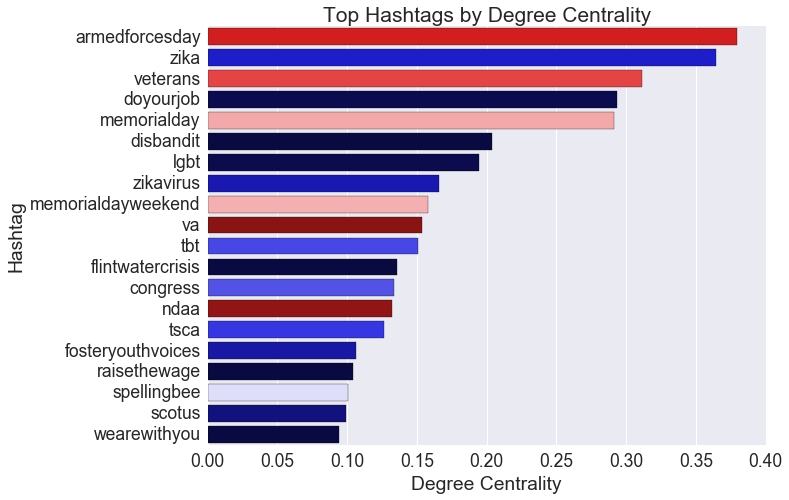

In [32]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="degree_centrality", 
                 y="tag", 
                 data=tag_degrees[:20], 
                 palette=tag_degrees[:20].color)
ax.set_ylabel('Hashtag')
ax.set_xlabel('Degree Centrality')
ax.set_title('Top Hashtags by Degree Centrality')
plt.show()

These are the top 20 hashtags in the graph by degree centrality.
I've set the color bars to scale with the relative percentages of Democrat/Republican uses, so a dark red is super-Republican, and a dark blue is super-Democrat.

The highest degree centrality goes to **#armedforcesday** - Armed Forces Day is on the third Saturday of May each year,
It's mostly red, but not _deep_ red, meaning there were some Democrats hashtagging this as well. 
This is pretty much the same story for **#zika**, except with the party roles reversed.
It's blue but not _deep_ blue.

More interesting are the really partisan topics. 
On the Republican side we've got **#va** (Veteran's Affairs) and **#ndaa** (the National Defense Authorization Act).
As it turns out, the week of the pull the head of the VA compared wait times at the VA hospitals to waiting in line at Disneyland.
Oops.
The National Defense Authorization Act is the budget bill for the military.
It's been (as of this writing) passed by the House.
It's a major legislative push they're trying to get through the Senate right now, but Senate Democrats may not play ball, presumably because they want to use it as leverage to get a hearing for Supreme Court nominee Merrick Garland, which segues nicely to some of our "most Democrat" hashtags.

On the Democrat side, we've got quite a few more of the top degree centrality hashtags that are very _very_ blue: **#doyourjob**, **#disbandit**, **#lgbt**, **#flintwatercrisis**, **#raisethewage**, and **#wearewithyou**.
Most of these are pretty obvious: raising the minimum wage, the [Flint water crisis](https://en.wikipedia.org/wiki/Flint_water_crisis), and LGBT rights (more on that last on in a moment).
**#doyourjob** is the rallying cry to get the Senate to hold a hearing for Merrick Garland, and it's clearly a consolidated Democrat effort.
Lately Democrats in both chambers have also been using it to criticize the lack of Republican response to the Zika virus, the Flint water crisis, and not cancelling upcoming summer recess that will start - and I am not joking - in _July_.

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Mosquitoes don’t go on recess in the summer. The Republican Congress is prepared to, without taking action on Zika. <a href="https://t.co/Lfd1ohMAyM">https://t.co/Lfd1ohMAyM</a></p>&mdash; Senator Harry Reid (@SenatorReid) <a href="https://twitter.com/SenatorReid/status/735500560275759105">May 25, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Mitch McConnell is not impressed, however, firing back with this tweet on the NDAA:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/DoYourJob?src=hash">#DoYourJob</a> Senate Democrats. Stop blocking <a href="https://twitter.com/hashtag/NDAA?src=hash">#NDAA</a> funding, especially on <a href="https://twitter.com/hashtag/MemorialDayWeekend?src=hash">#MemorialDayWeekend</a>.<a href="https://t.co/eKAhVfIAuu">https://t.co/eKAhVfIAuu</a></p>&mdash; Leader McConnell (@SenateMajLdr) <a href="https://twitter.com/SenateMajLdr/status/735856675568025600">May 26, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Burned.

Also of interest is **#disbandit**, which is a Democrat rally around disbanding a panel on fetal tissue research following the Planned Parenthood "scandal" that turned out to be pretty much [nothing](https://en.wikipedia.org/wiki/Planned_Parenthood_2015_undercover_videos_controversy#Investigations).
The hashtag **#wearewithyou**, while pretty generic, likely refers to an LGBT protection amendment authored by [Sean Patrick Maloney](https://twitter.com/RepSeanMaloney) that affords protections of LGBT federal contractors.
**#lgbt** is another top hashtag, so it was clearly a hot topic this week.

Finally, the topic Congress seemed to agree the most on (i.e. neither red nor blue), was **#spellingbee** - the National Spelling Bee was also occurring the week I pulled the data.
Way to agree on what matters, Congress.

Another more complicated measure we can apply to the graph is call [PageRank](https://en.wikipedia.org/wiki/PageRank), created by [Sergey Brin and Eric Schmidt](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to improve search results for their search engine side project.
It's designed to measure the importance or influence of a node in a graph, which turns out to be a complicated problem, particularly for very large networks.
It's a little complicated to compute, but what you end up with for each node is the probability that if you're traversing the graph (meaning traveling from node to node via the edges) you're on that particular node.
It's easy to see how well this applies to websites, where the nodes are things people literally visit via the edges (links).
For this graph it requires a little interpretation.

This is a slightly imperfect but concrete example that will hopefully give you an idea of what PageRank tells you.
Imagine you're looking at a random tweet with a hashtag by someone in Congress.
Click the first hashtag, which takes you to the search page.
Now hit the profile of the first person in Congress in the search page.
Find a random tweet of theirs with a hashtag, and hit the hashtag.
If you repeat this enough, you'd notice certain hashtags keep coming up a lot more often than others.
What do those hashtags tell you?
Well, they're the _themes_ of the "discussion".
What you're following is a discussion with a lot of different concepts (tags), all connected by who's talking about them.
The hashtags with the highest PageRank are the ones that appear the most often when you follow the _structure_ of the conversation: the edges.
(The weight of the edges that was calculated earlier also plays a role, but it was a little much to include in the example).
So which hashtags have the highest PageRank in this dataset?

In [33]:
# Top page rank.
tag_pageranks = pd.DataFrame.from_dict(nx.pagerank(tag_graph), orient='index')\
                          .rename(columns={0:'pagerank'}).join(tag_nodes,how='inner')\
                          .sort_values('pagerank', ascending=False)
        
tag_pageranks['tag'] = tag_pageranks.index
tag_pageranks['color'] = [get_color(r.party_r, r.party_d) for r in tag_pageranks.itertuples()]

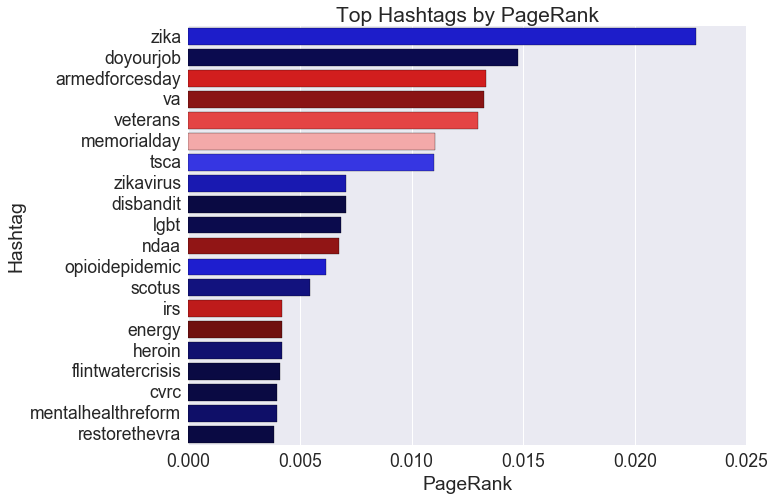

In [34]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x="pagerank", 
                 y="tag", 
                 data=tag_pageranks[:20], 
                 palette=tag_pageranks[:20].color)
ax.set_ylabel('Hashtag')
ax.set_xlabel('PageRank')
ax.set_title('Top Hashtags by PageRank')
plt.show()

Most of these topics appeared in the top degree centrality nodes.
Given how PageRank works, that's not surprising.
Their relative orders are different, however.
**#tcsa** has a higher relative PageRank than degree centrality, and it's a really interesting one.
The TCSA is the Toxic Substance Control Act, passed in the seventies.
An update to it, called the Toxic Substance Modernization Control Act was passed in the House with an overwhelming bipartisan majority.
The update gives more authority to the EPA to regulate more chemicals in addition to the ones that they already regulate, and grants additional powers to force companies to perform more studies.
It is currently (as of May 30) delayed in the Senate so Rand Paul can read it.
[Seriously](http://tscatodaybna.wpengine.com/?p=250).

Also of interest is the _super_ blue one at the bottom **#RestoreTheVRA**.
The VRA is the Voting Rights Act, which was substantially weakened by the Supreme Court in 2013 when they ruled states could change their voting laws without federal approval.
What happened almost immediately thereafter was that several states in the South immediately enacted voter ID laws, making it more difficult for some people to vote.
An all-Democrat Senate caucus was formed to oversee the possibility of rewriting the law for another round.
It's not surprising to see this on the table since the election is coming up, and I suspect we'll see it grow as November approaches.

## Politican to Politician

Another way to build a network from this data is to treat each politician as a node, and draw an edge when they use the same hashtag.
This graph is a little easier to think about because it can be interpreted as the propagation of political messaging through a network of people.
In order to properly capture this propagation we need to embed _time_ into the graph.
To do this, we treat edges as _directed_, that is, there's only one way the relationship flows; think Facebook friends (friendships are mutual) vs Twitter followers (edges go out from followers into the people they follow).
So to embed time we need to make the edges flow from the person who used the hashtag _first_.
So if Paul Ryan tweets #ConfidentAmerica &#x1F644; &nbsp; and Mitch McConnell tweets it two hours later, the edge would go from Paul Ryan to Mitch McConnell.

In [35]:
# The nodes for this graph are a lot simpler to compute, since we pretty much have all of the
# properties we need.
# Basically we just have to re-index on the hashtags instead of the names, 
# since the hashtag will be the new join key.
# Pull the screen names out of the index.
hashtags_by_congress = hashtags.copy()
hashtags_by_congress['name'] = hashtags_by_congress.index
# Reindex with the hashtag.
hashtags_by_congress.index = hashtags_by_congress.tag

In [36]:
# First create the unordered edges by performing a self-join.
congress_unord_edges = hashtags_by_congress.join(hashtags_by_congress, 
                                                 how='inner', 
                                                 lsuffix='_f', 
                                                 rsuffix='_s')

# Now filter out self loops.
different_congress = congress_unord_edges.name_f != congress_unord_edges.name_s
# And keep only tweets when tag_f occurred before tag_s.
in_order_congress = congress_unord_edges.time_f <= congress_unord_edges.time_s

# Now reduce and get the counts for the edge weights.
congress_ord_edges = congress_unord_edges[different_congress & in_order_congress]\
                         .drop(['tag_f','tag_s','time_f', 'time_s'],1)\
                         .groupby(['name_f','name_s'])\
                         .size()

In [37]:
# Now throw this one into networkx. This should be a directed graph.
congress_graph = nx.DiGraph()

for row in congress.itertuples():
    congress_graph.add_node(row.Index,
                            name=row.name,
                            party=row.party)
    
for row in congress_ord_edges.iteritems():
    congress_graph.add_edge(row[0][0], row[0][1], weight=int(row[1]))

In [38]:
nx.write_gexf(congress_graph, 'congress_graph.gexf')

Here's what that graph looks like in Gephi.

![](congress_graph.png)

As before, if you're running the notebook, the graph was saved into a file that can be imported into Gephi for further exploration.

This is a more tightly connected graph than the hashtags, but there's still a clear party line.
There are two independent members of Congress: Angus King of Maine and Bernie Sanders of Vermont.
They're white dots on the graph.
Based on the picture above, it's clear they lean Democrat.
Angus King caucuses with the Democrats, and Bernie Sanders is running for the Democratic nomination for President.
By the way, note how _obvious_ it is they lean Democrat when you see the data as a graph - this is clear just from the _hashtags_ they use on Twitter.
Imagine what someone can tell from a graph of who _you're_ Tweeting/Facebooking with.

We can look at all the same two metrics we did for the other graph, but the interpretation is a _little_ different.
For degree centrality, we're basically just looking at the number of hashtags used by someone (as long as that hashtag is used by someone else).
As mentioned earlier, degree centrality doesn't necessarily correlate directly with importance; that's what PageRank is for.
For example, someone could just retweet everything everybody from their party says and shoot to the top, which doesn't really peg the person as an influencer.

In [39]:
# Degree centrality.
congress_degrees = pd.DataFrame.from_dict(nx.degree_centrality(congress_graph), 
                                          orient='index')\
                               .rename(columns={0:'degree_centrality'})\
                               .join(congress,how='inner')\
                               .sort_values('degree_centrality', ascending=False)


party_colors = {'R':'red','D':'blue','I':'white'}

congress_degrees['color'] = [party_colors[r.party] for r in congress_degrees.itertuples()]

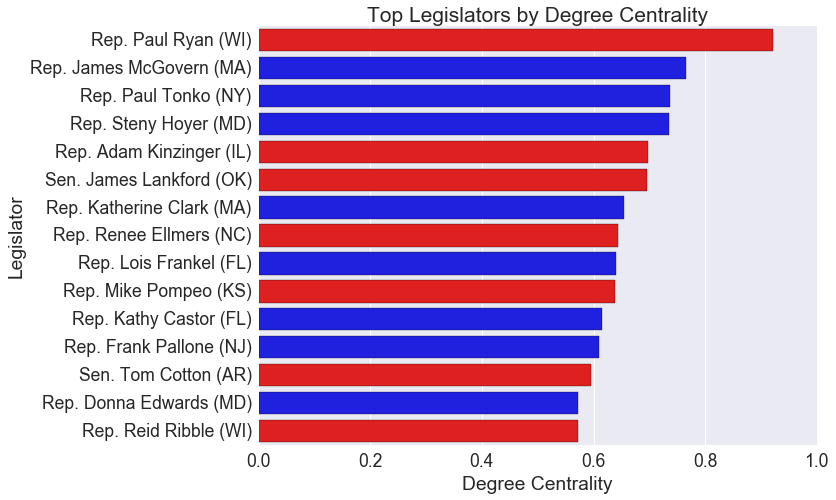

In [40]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x='degree_centrality', 
                 y='name', 
                 data=congress_degrees[:15],
                 palette=congress_degrees.color[:15])
ax.set_xlabel('Degree Centrality')
ax.set_ylabel('Legislator')
ax.set_title('Top Legislators by Degree Centrality')
plt.show()

Perhaps not surprisingly, Paul Ryan handily tops the degree centrality list.
He's the de facto leader of the GOP, and has a very solid social media presence.
The top Democrat is James (Jim) McGovern.
Browsing his [timeline](https://twitter.com/RepMcGovern) makes it clear he's got his thumbs on the pulse of the top Democrat topics.
Conspicuously absent are the Democrat's leaders, Nancy Pelosi and Harry Reid.
With zingers like the Harry Reid Zika slam we saw earlier, it's not hard to see why.

The PageRank is a lot more interesting.
The interpretation is a lot more straightforward than the hashtag graph.
Imagine you're browsing a legislator's timeline - as one does - and you click on a random hashtag.
You're taken to the search page, where you then hit another legislator's timeline, and find another hashtag.
The legislators who appear the most will be the ones "distributing" the hashtags more than the rest, meaning they're the ones influencing the "dialogue".
PageRank will literally tell us who the most important people in Congress are, assuming Twitter hashtags are how legislators exchange ideas.
Which is totally true.

In [41]:
# PageRank.
congress_pageranks = pd.DataFrame.from_dict(nx.pagerank(congress_graph), orient='index')\
                                 .rename(columns={0:'pagerank'}).join(congress,how='inner')\
                                 .sort_values('pagerank', ascending=False)
        
congress_pageranks['color'] = [party_colors[r.party] for r in congress_pageranks.itertuples()]

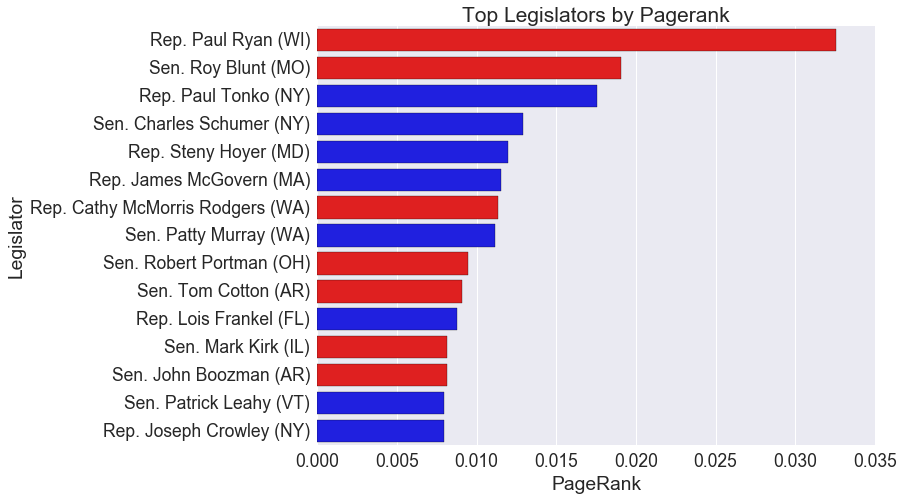

In [42]:
plt.figure(figsize=(10,7.5))
ax = sns.barplot(x='pagerank', 
                 y='name', 
                 data=congress_pageranks[:15],
                 palette=congress_pageranks.color[:15])
ax.set_xlabel('PageRank')
ax.set_ylabel('Legislator')
ax.set_title('Top Legislators by Pagerank')
plt.show()

Once again, and this time by a bigger margin, Paul Ryan tops the PageRank ... rankings.
No surprise given his position in the party, but it is pretty cool that Twitter hashtags reflect his position as well.
Second on the list is Roy Blunt, a Senator from Missouri.
This week he called on the head of the VA to resign after the whole Disneyland remark, so he's been tweeting a lot about a central topic.

The top Democrat is one Paul Tonko, a Representative from the state of New York.
He's on the list because he is a tweeting [machine](https://twitter.com/RepPaulTonko).
Seriously his whole timeline is one long tweetstorm, and he hits all the main hashtag points relevant to the party.
I don't think his PageRank status is unwarranted, but I do have some carpal tunnel concerns.

The final thing we'll look at is related to messageing _cohesion_.
Do the Republicans and Democrats have a cohesive agenda they're trying to put forward, or are they disorganized?

Unfortunately there isn't a single simple metric for calculating this type of thing.
One option is the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient), which measures how well connected the neighbors of a node are.
It turns out that because this graph is very "dense" (highly interconnected) the clustering coefficient doesn't tell use very much.
If you're running the notebook you can give it a shot, but prepare to be underwhelmed.

A less conventional way is to look at what are called [cliques](https://en.wikipedia.org/wiki/Clique_(graph_theory)), which are subsets of the graph such that all of the nodes are connected.
The "globs" of nodes in the hashtag graph are probably cliques.
Now comes the unconventional part: we're going to find the cliques in the graph and classify them by political party: all Republican, all Democrat, or mixed.
Then we're going to look at the distribution of sizes clique sizes, which we'll do with a [boxplot](https://en.wikipedia.org/wiki/Box_plot)).
What we're looking for is whether the boxes for each of the three categories are roughly in the same spot (all equally cohesive), or if one of them is significantly higher/lower than the others.
We'll account for the fact that there are more Republicans than Democrats in Congress by dividing the clique size by the total number of legislators in the party.
That way we get a view of the _relative_ cohesion that we need.

In [43]:
def classify_clique(clique):
    clique_party_counts = congress.ix[clique].groupby(['party']).size()
    if len(clique_party_counts) > 1:
        return 'M'
    else:
        return clique_party_counts.index[0]

In [44]:
# This one takes a minute.
clique_parties = pd.DataFrame([{'party': classify_clique(c), 'clique_size': len(c)} 
                                for c in nx.find_cliques(congress_graph.to_undirected())])

In [45]:
# Now we need to normalize the sizes of the cliques so we count the Democrats and Republicans equally.
total_dems = len(congress[congress.party == 'D'])
total_reps = len(congress[congress.party == 'R'])
total_congress = len(congress)

clique_parties['size_normalized'] = 0.0
clique_parties.loc[clique_parties.party == 'R', 'size_normalized'] = \
    clique_parties[clique_parties.party == 'R'].clique_size / total_reps
clique_parties.loc[clique_parties.party == 'D', 'size_normalized'] = \
    clique_parties[clique_parties.party == 'D'].clique_size / total_dems
clique_parties.loc[clique_parties.party == 'M', 'size_normalized'] = \
    clique_parties[clique_parties.party == 'M'].clique_size / total_congress


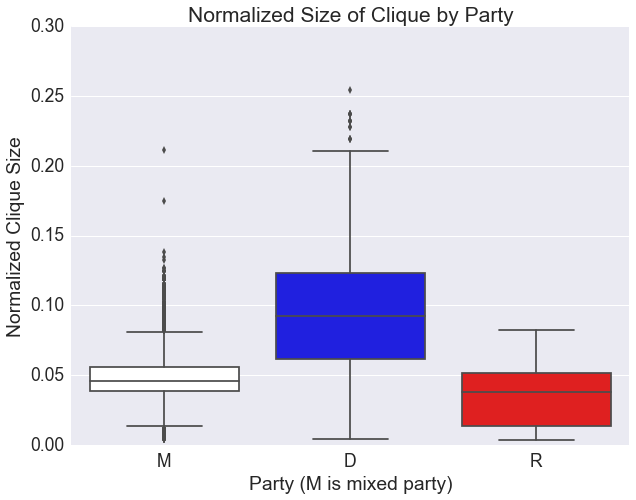

In [46]:
plt.figure(figsize=(10,7.5))
ax = sns.boxplot(x='party', 
                 y='size_normalized', 
                 data=clique_parties, 
                 order=['M','D','R'], 
                 palette=['white','blue','red'])

ax.set_title('Normalized Size of Clique by Party')
ax.set_ylabel('Normalized Clique Size')
ax.set_xlabel('Party (M is mixed party)')
plt.show()

This plot makes it obvious: the Democrats are clearly more consistent with one another in their messaging than the Republicans are.
Most of the cliques that are all-Democrat are significantly larger than nearly _all_ of the cliques that are all-Republican, which means larger groups of Democrats are using the same set of hashtags.
The Republican legislators are much less cohesive in their messaging.
I hesitate to outright say this is a reflection of the rifts in the party between Tea Party conservatives and establishment Republicans, but it does look suspicious that there are far smaller groups all putting the same messaging forward.

## Future Work

There's obviously a lot more we can do with this dataset (or an updated version of it, anyway).
For one thing, the models could be improved to include who's actually following whom on Twitter.
This more accurately captures the nature of on-Twitter interactions.
Another cool improvement we could add is adjusting the edge weights to take into account how long ago the connection was made.
So for the hashtag graph we'd weigh an edge between hashtags more heavily when the person tweeting them does so in quick succession, while putting smaller weights on tags that were used farther apart.
The same goes for the Congress graph - make a heavier edge when one legislator uses it immediately after another.
Still, even with the relatively basic analysis done here there's a lot to see.